<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project**
    
Hi Breeanna — thanks for the clear notebook and the healthy mix of classic (TF-IDF + LR) and more experimental (LightGBM / BERT) models. 
    
Your best model already **meets the ≥ 0.85 F1 requirement (≈ 0.88)**, and the story is easy to follow. Below are a few light-touch edits that will get the project fully approval-ready.

---
    
**✅  What’s working well**

| ✔︎ | Highlight |
|---|-----------|
| **Clean data pipeline** — duplicates removed, missing values handled, non-numeric entries converted. |
| **Thoughtful EDA**: histograms, KDE & year-over-year plots all include titles / labels. |
| **Baseline ➜ Multiple models**: you start with a dummy classifier then iterate through three solid text models and a small BERT demo. |
| **Custom evaluation helper** nicely shows F1/ROC/PR in one view. |
| **Result interpretation**: quick commentary after each experiment and a concise final recommendation. |

Keep those elements; they make the notebook enjoyable to read.

---

**🔑  Quick tweaks before final approval**

| # | What to adjust | Why it matters | One-line fix |
|---|----------------|----------------|--------------|
| **1** | **Switch the dummy baseline to `strategy="most_frequent"`** (or `stratified`). | “Constant = 1” assumes *all* reviews are positive, which in a ~50/50 set inflates F1 ≈ 0.66. A most-frequent baseline shows the true lift of your models (F1 ≈ 0). | `DummyClassifier(strategy="most_frequent").fit(X_train, y_train)` |
| **2** | **Optional:** call `evaluate_model` for the dummy model too. | Gives a consistent dashboard and makes it easy to compare curves. | One extra line: `evaluate_model(dummy_clf, X_train_vect, y_train, X_test_vect, y_test)` |

---

**✨  Nice-to-have polish (no impact on approval)**

* Add `class_weight="balanced"` to your LR fit — might squeeze another 0.5-1 pp F1.  
* Consider dropping/keeping the “‘runtime_minutes’ histogram” cell *after* conversion to numeric so the plot isn’t doubled.

---

**🚀  Approval checklist**

| Status | Item |
|:--:|---|
| ☐ | Dummy baseline uses **`most_frequent`** (and F1 ≈ 0). |

Tick that box and you’re all set.  
    
Great job, Breeanna — you’re very close to the finish line!


<div class="alert alert-info">    
Hello! Thank you for reviewing my project and letting me know where I can improve. Let me know if this is better!
</div>

<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project Iter 2**
    
Congrats on your approval, Breeanna!! Loved your project ;)

# Sprint 14 Project: Negative Review Model

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re

from sklearn.metrics import f1_score, accuracy_score

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
30280,tt0846119,tvMovie,Seventeen and Missing,Seventeen and Missing,2007,\N,90,0,"Mystery,Thriller",4.9,402,I loved Dedee Pfeiffer (is that spelled right?...,8,pos,1,train,268
5469,tt0028653,movie,Born to the West,Born to the West,1937,\N,59,0,"Action,Adventure,Romance",5.7,767,Dare Rudd (John Wayne) and sidekick Dink Hoole...,4,neg,0,test,6999
28901,tt0107977,movie,Robin Hood: Men in Tights,Robin Hood: Men in Tights,1993,\N,104,0,"Adventure,Comedy,Musical",6.7,112981,Mel Brooks really outdid himself with this hil...,10,pos,1,test,3064
40575,tt0828154,movie,The Pervert's Guide to Cinema,The Pervert's Guide to Cinema,2006,\N,150,0,Documentary,7.8,6097,"His choice of films, the basic 'conceit' of th...",9,pos,1,train,1465
14869,tt0455957,movie,Goya's Ghosts,Goya's Ghosts,2006,\N,113,0,"Biography,Drama,History",6.9,28903,"Having watched this movie several times, I hav...",4,neg,0,test,8879
22648,tt0365514,movie,Moon Child,Moon Child,2003,\N,120,0,"Action,Drama,Sci-Fi",6.4,1960,I got this movie from Netflix after a long wai...,9,pos,1,train,2517
39351,tt0211492,movie,The Luzhin Defence,The Luzhin Defence,2000,\N,109,0,"Drama,Romance",6.8,4160,I fell in love with Emily Watson in Breaking t...,10,pos,1,train,464
21708,tt0095593,movie,Married to the Mob,Married to the Mob,1988,\N,104,0,"Comedy,Crime,Romance",6.2,15647,Michelle Pfeiffer stars as a mob widow who see...,8,pos,1,test,5532
12229,tt0388595,tvSeries,Extreme Makeover: Home Edition,Extreme Makeover: Home Edition,2003,2020,60,0,"Comedy,Drama,Family",6.3,4429,There is a uk edition to this show which is ra...,1,neg,0,train,5107
34492,tt0443441,movie,The Beach Party at the Threshold of Hell,The Beach Party at the Threshold of Hell,2006,\N,90,0,Comedy,4.2,459,This is the biggest pile of crap I have ever w...,1,neg,0,train,10243


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
print("Duplicates before:", df_reviews.duplicated().sum())
df_reviews = df_reviews.drop_duplicates()
print("Duplicates after:", df_reviews.duplicated().sum())

Duplicates before: 0
Duplicates after: 0


In [8]:
df_reviews['end_year'] = pd.to_numeric(df_reviews['end_year'].replace('\\N', np.nan), errors='coerce')

In [9]:
print(df_reviews['runtime_minutes'].unique())

['121' '25' '88' '85' '90' '113' '96' '99' '43' '82' '74' '100' '95' '129'
 '60' '92' '98' '104' '94' '116' '102' '141' '89' '120' '180' '97' '107'
 '87' '44' '149' '130' '40' '45' '84' '30' '\\N' '70' '126' '110' '93'
 '80' '78' '8' '118' '123' '106' '79' '109' '112' '139' '117' '46' '135'
 '31' '12' '1' '72' '58' '77' '150' '7' '101' '91' '138' '10' '108' '105'
 '61' '69' '152' '47' '65' '23' '119' '374' '225' '66' '71' '15' '114'
 '83' '20' '301' '216' '148' '155' '251' '67' '177' '103' '62' '81' '111'
 '140' '125' '122' '124' '76' '146' '42' '50' '400' '73' '115' '75' '200'
 '22' '133' '160' '86' '21' '128' '230' '29' '162' '127' '147' '53' '13'
 '151' '9' '278' '179' '63' '137' '59' '165' '1140' '263' '54' '143' '183'
 '131' '51' '157' '132' '64' '57' '11' '49' '5' '27' '17' '136' '175' '56'
 '14' '208' '156' '244' '144' '34' '167' '52' '55' '154' '360' '199' '19'
 '48' '178' '189' '41' '185' '145' '153' '18' '24' '176' '35' '265' '197'
 '68' '142' '6' '33' '134' '26' '3' '181' '1

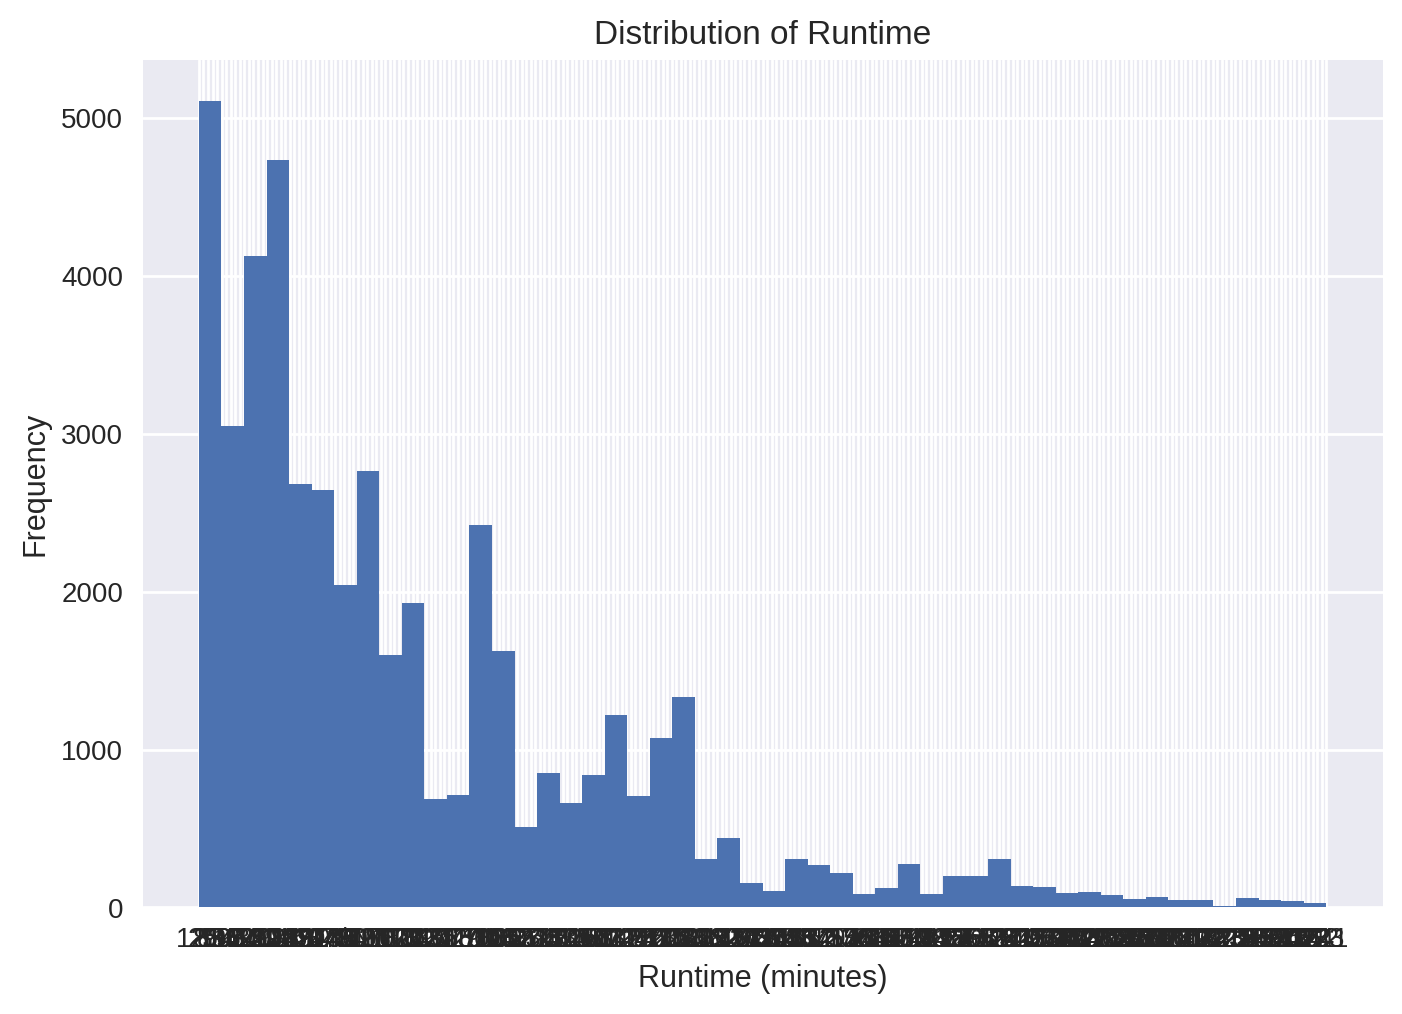

In [10]:
df_reviews['runtime_minutes'].hist(bins=50)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Runtime')
plt.show()

In [11]:
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'].replace('\\N', np.nan), errors='coerce')


median_runtime = df_reviews['runtime_minutes'].median()
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].fillna(median_runtime)

In [12]:
df_reviews = df_reviews.dropna(subset=['average_rating', 'votes'])

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         2279 non-null   float64
 6   runtime_minutes  47329 non-null  float64
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

In [13]:
df_reviews = df_reviews.drop(columns=['end_year'])

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   runtime_minutes  47329 non-null  float64
 6   is_adult         47329 non-null  int64  
 7   genres           47329 non-null  object 
 8   average_rating   47329 non-null  float64
 9   votes            47329 non-null  Int64  
 10  review           47329 non-null  object 
 11  rating           47329 non-null  int64  
 12  sp               47329 non-null  object 
 13  pos              47329 non-null  int64  
 14  ds_part          47329 non-null  object 
 15  idx              47329 non-null  int64  
dtypes: Int64(1), float64(2), int64(5), object(8)
memory usage:

- Checked for duplicates
- Filled in missing values

## EDA

Let's check the number of movies and reviews over years.

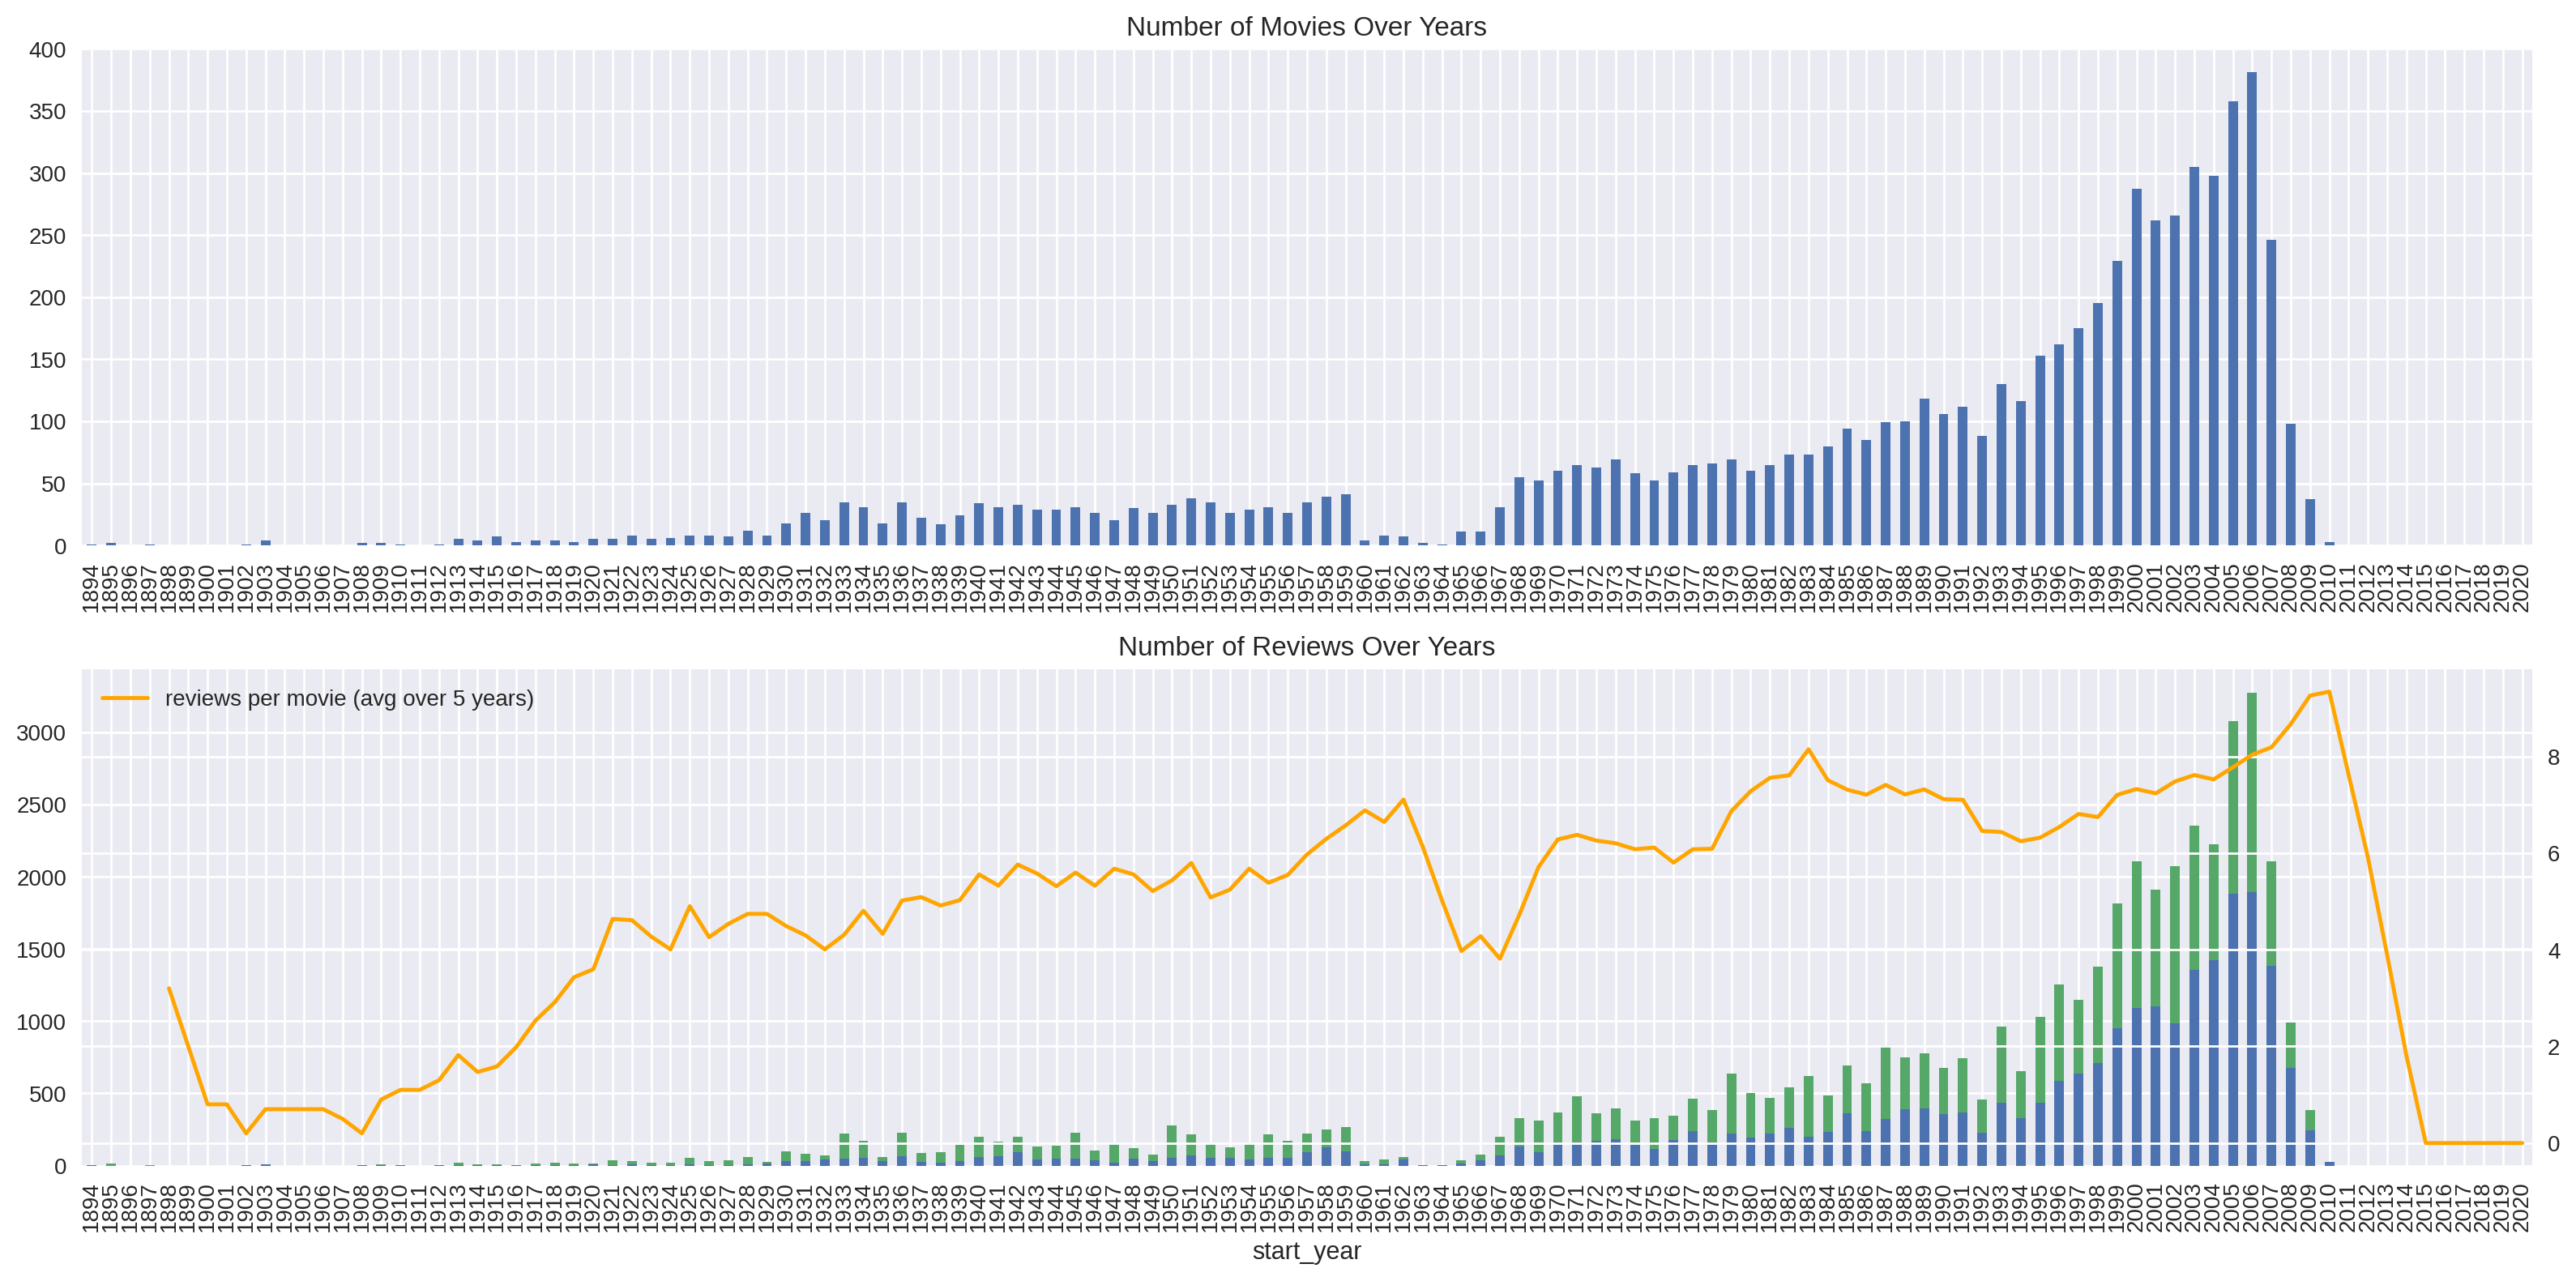

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

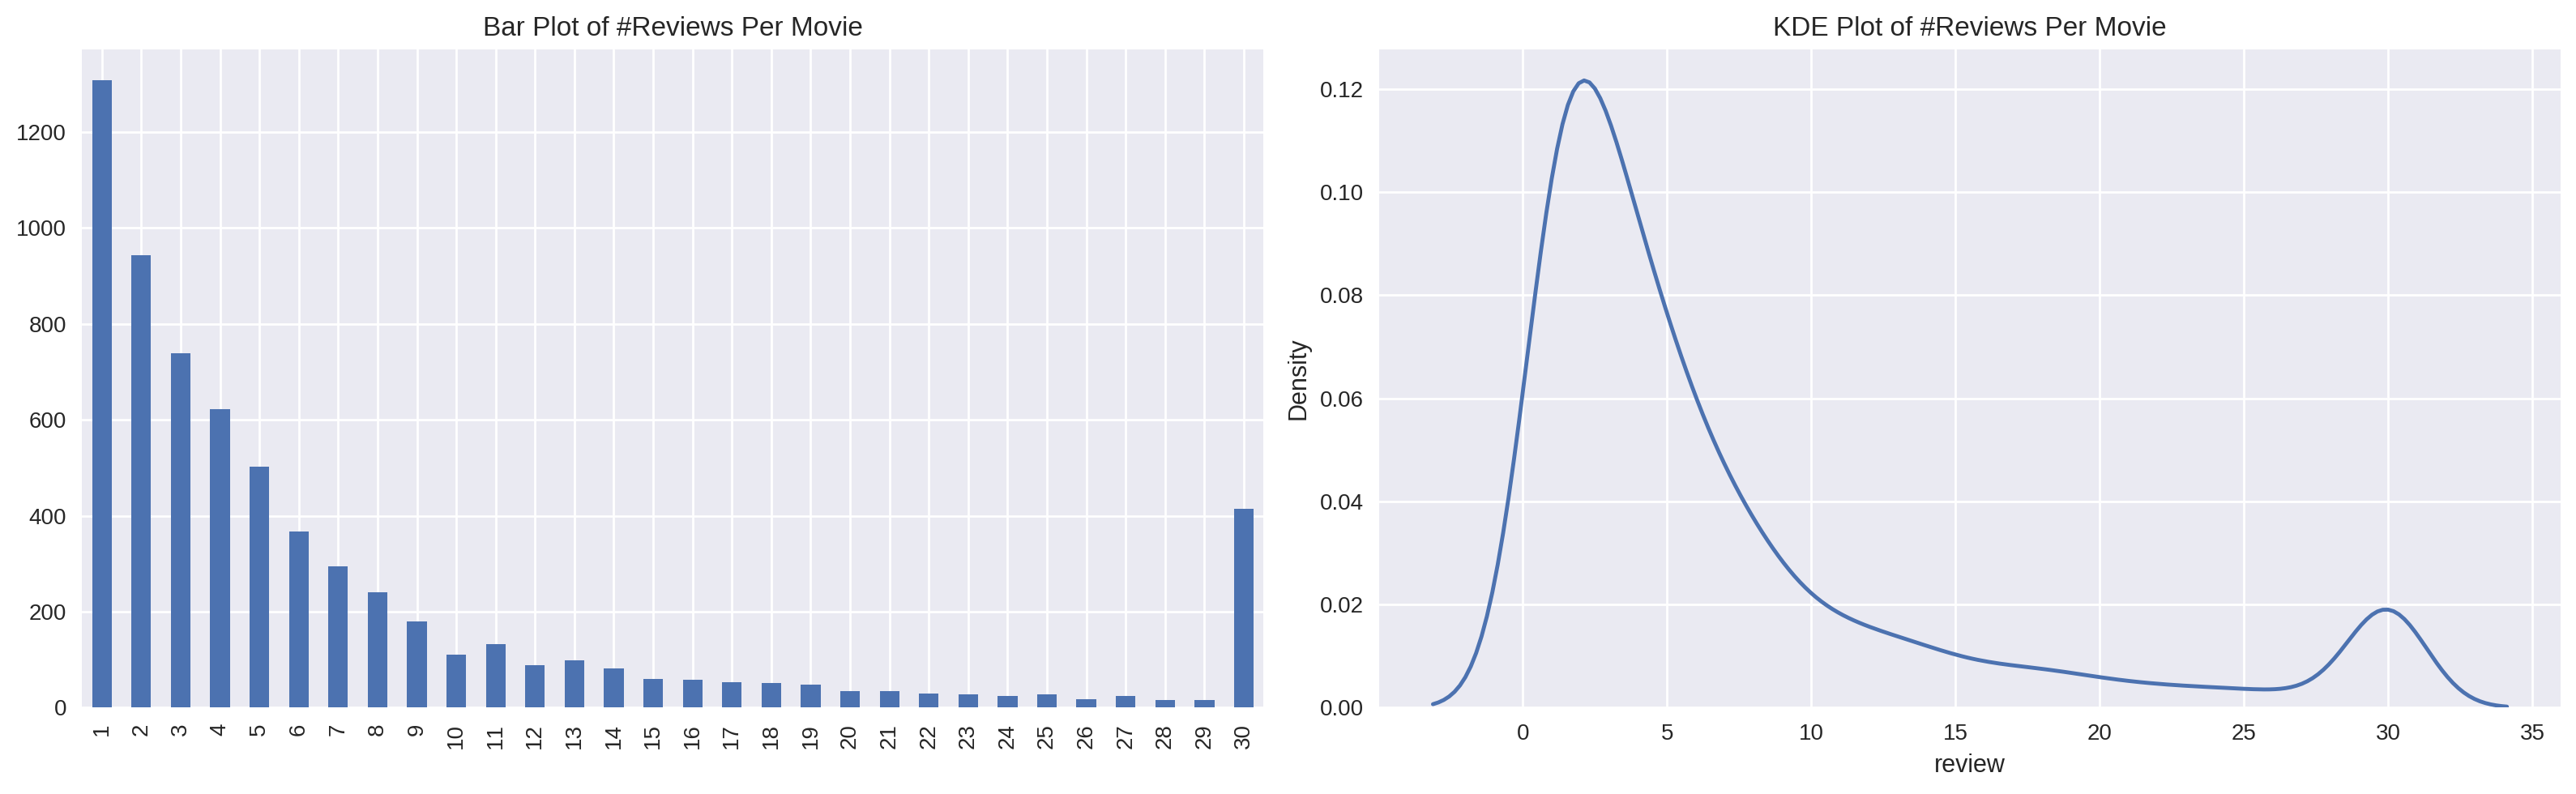

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [16]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

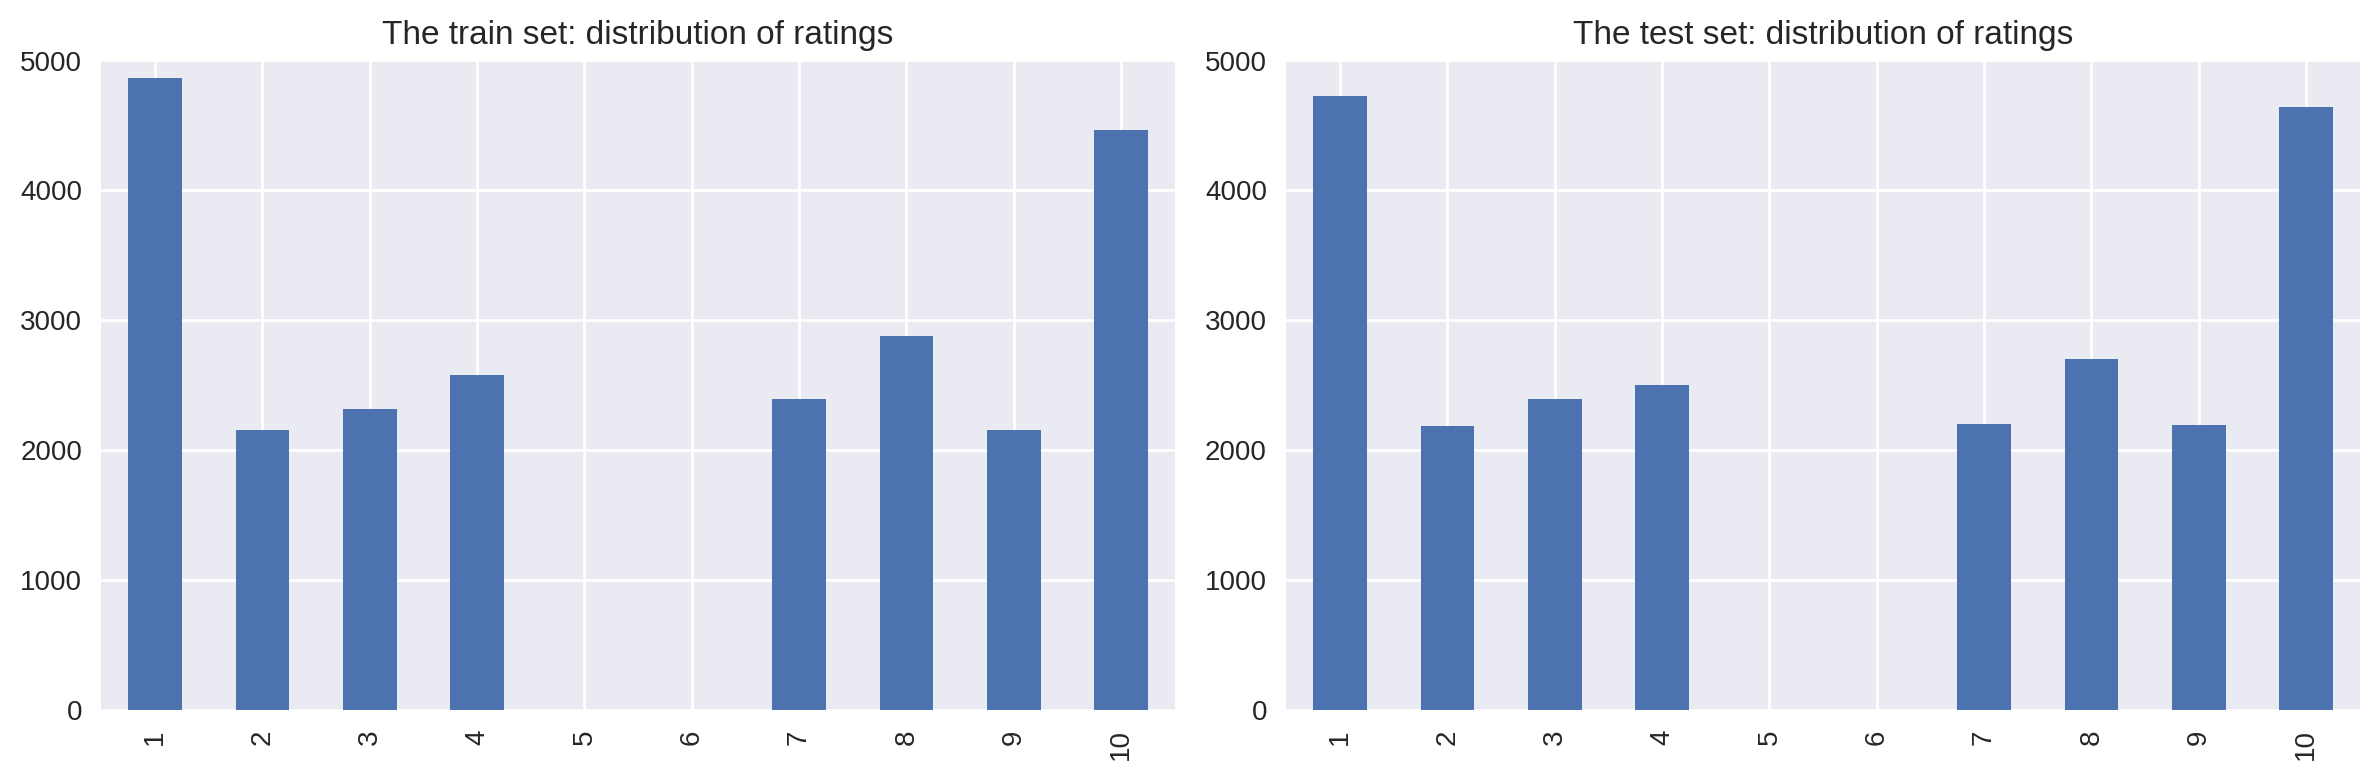

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


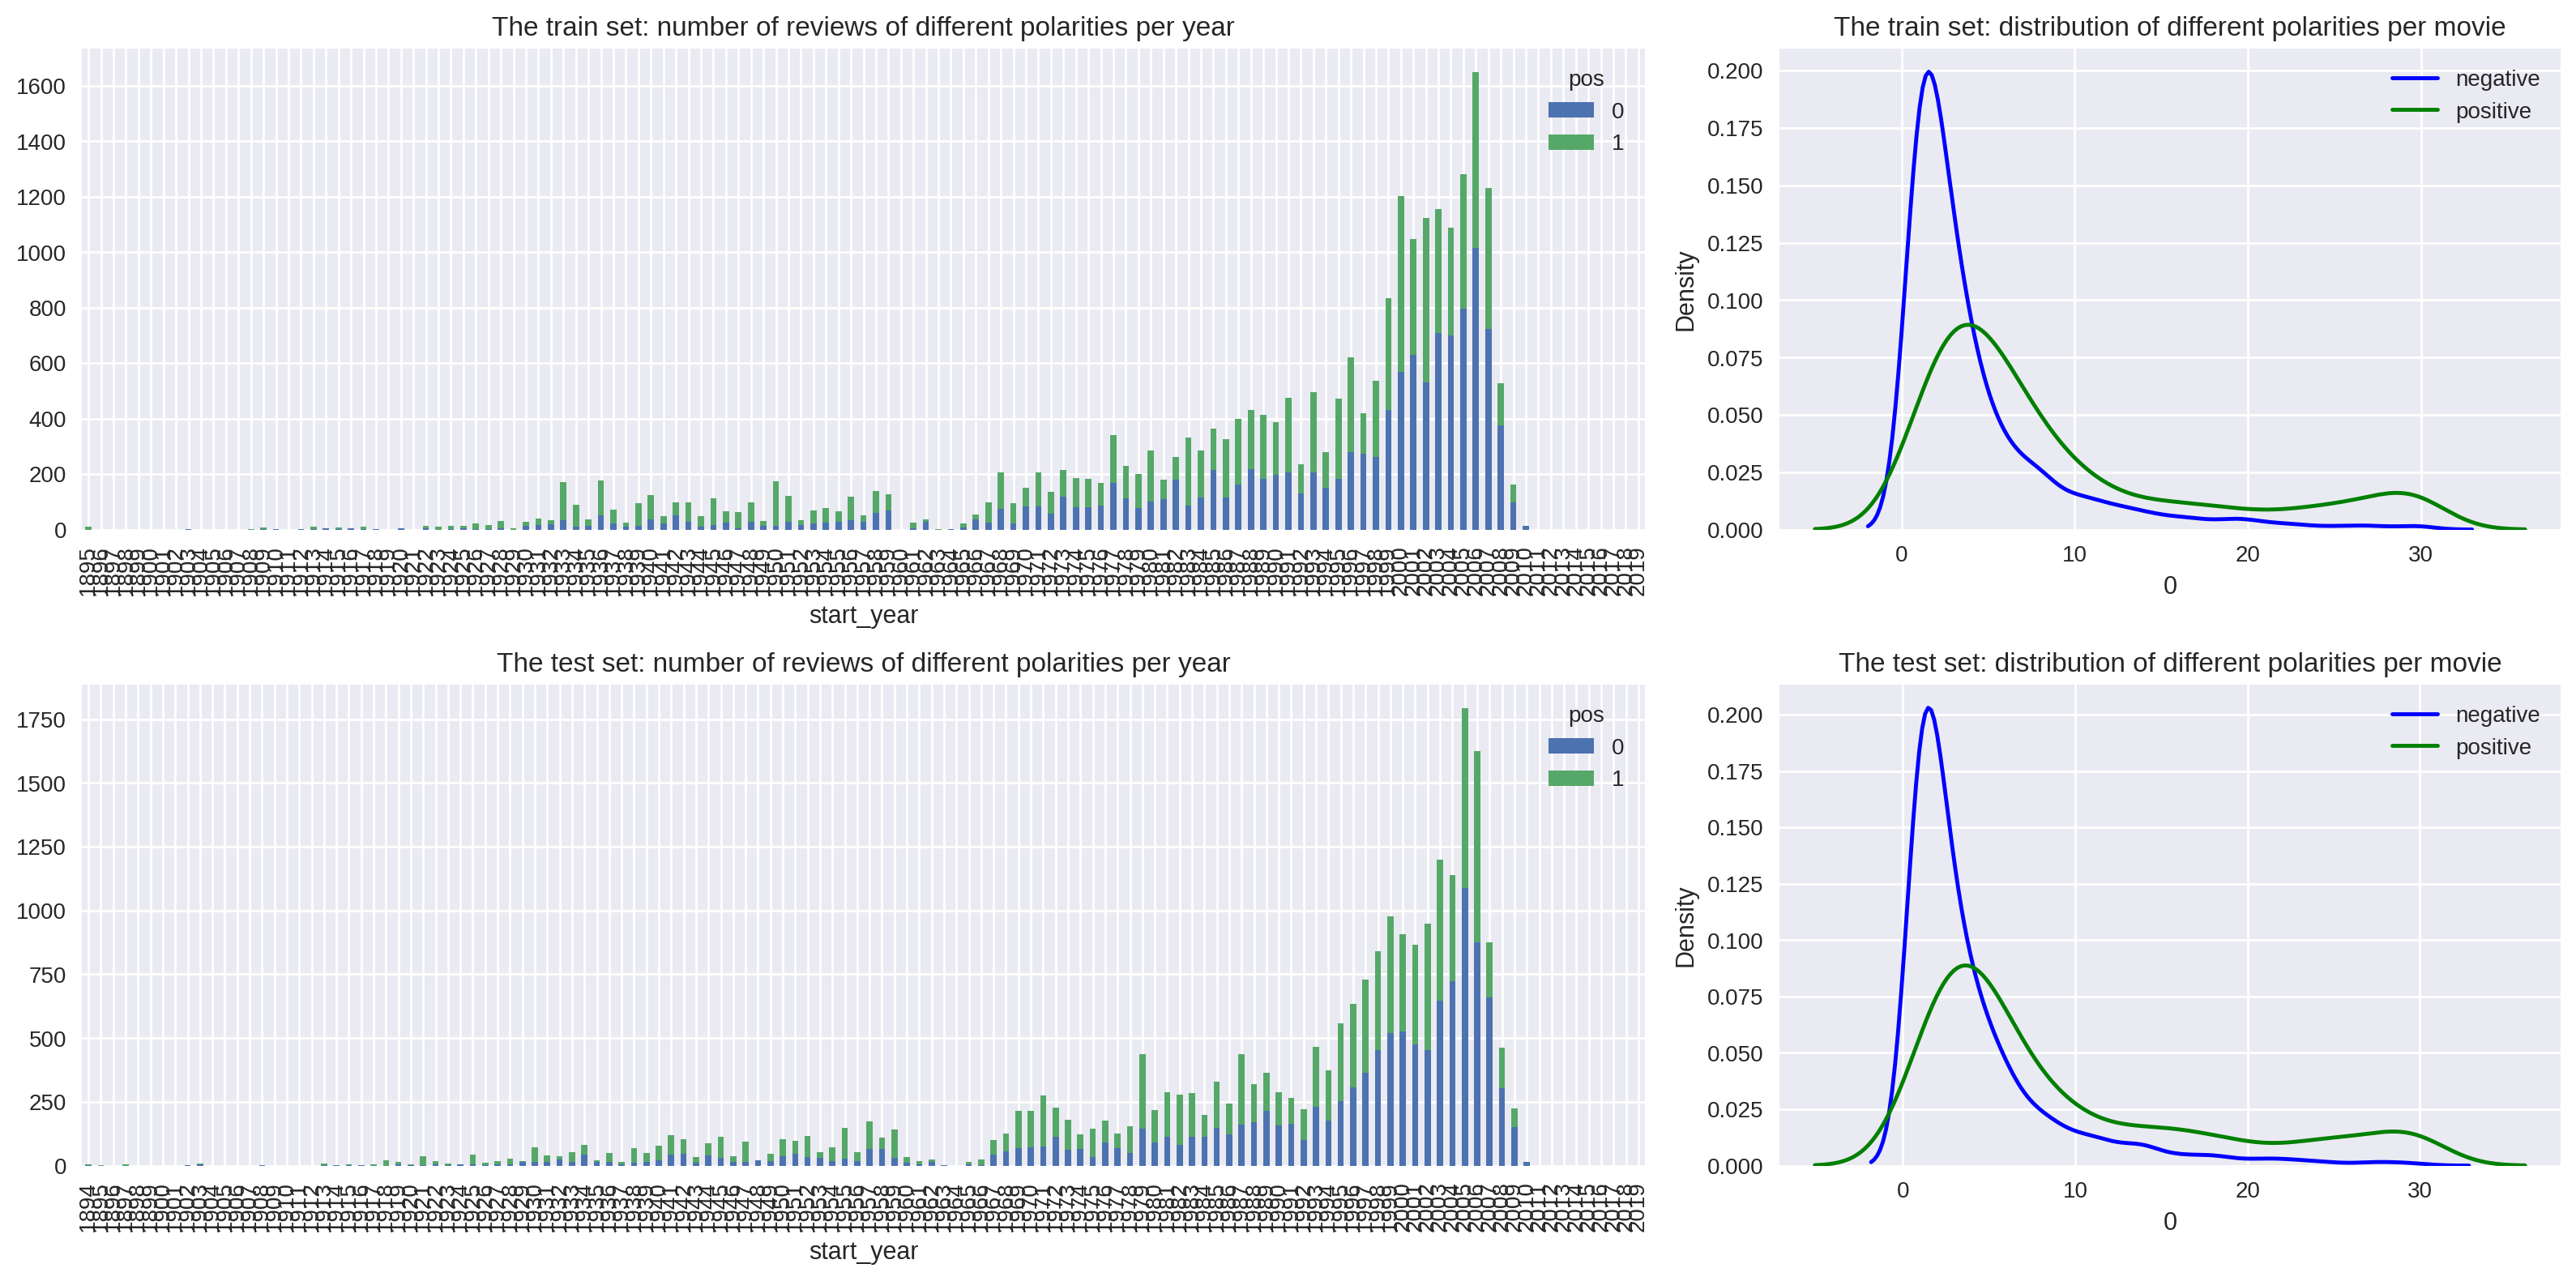

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [19]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [20]:
df_reviews['review_norm'] = df_reviews['review'].apply(
    lambda x: re.sub(r'[^a-z\s]', '', x.lower())
) # <put your code here>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [21]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 17)
(23533, 17)


## Working with models

In [22]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

### Model 0 - Constant

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
dummy_constant = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_constant.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [25]:
y_pred = dummy_constant.predict(X_test_vect)

Accuracy: Constant Model: 0.5015510134704457
F1 Score: Contant Model 0.0
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


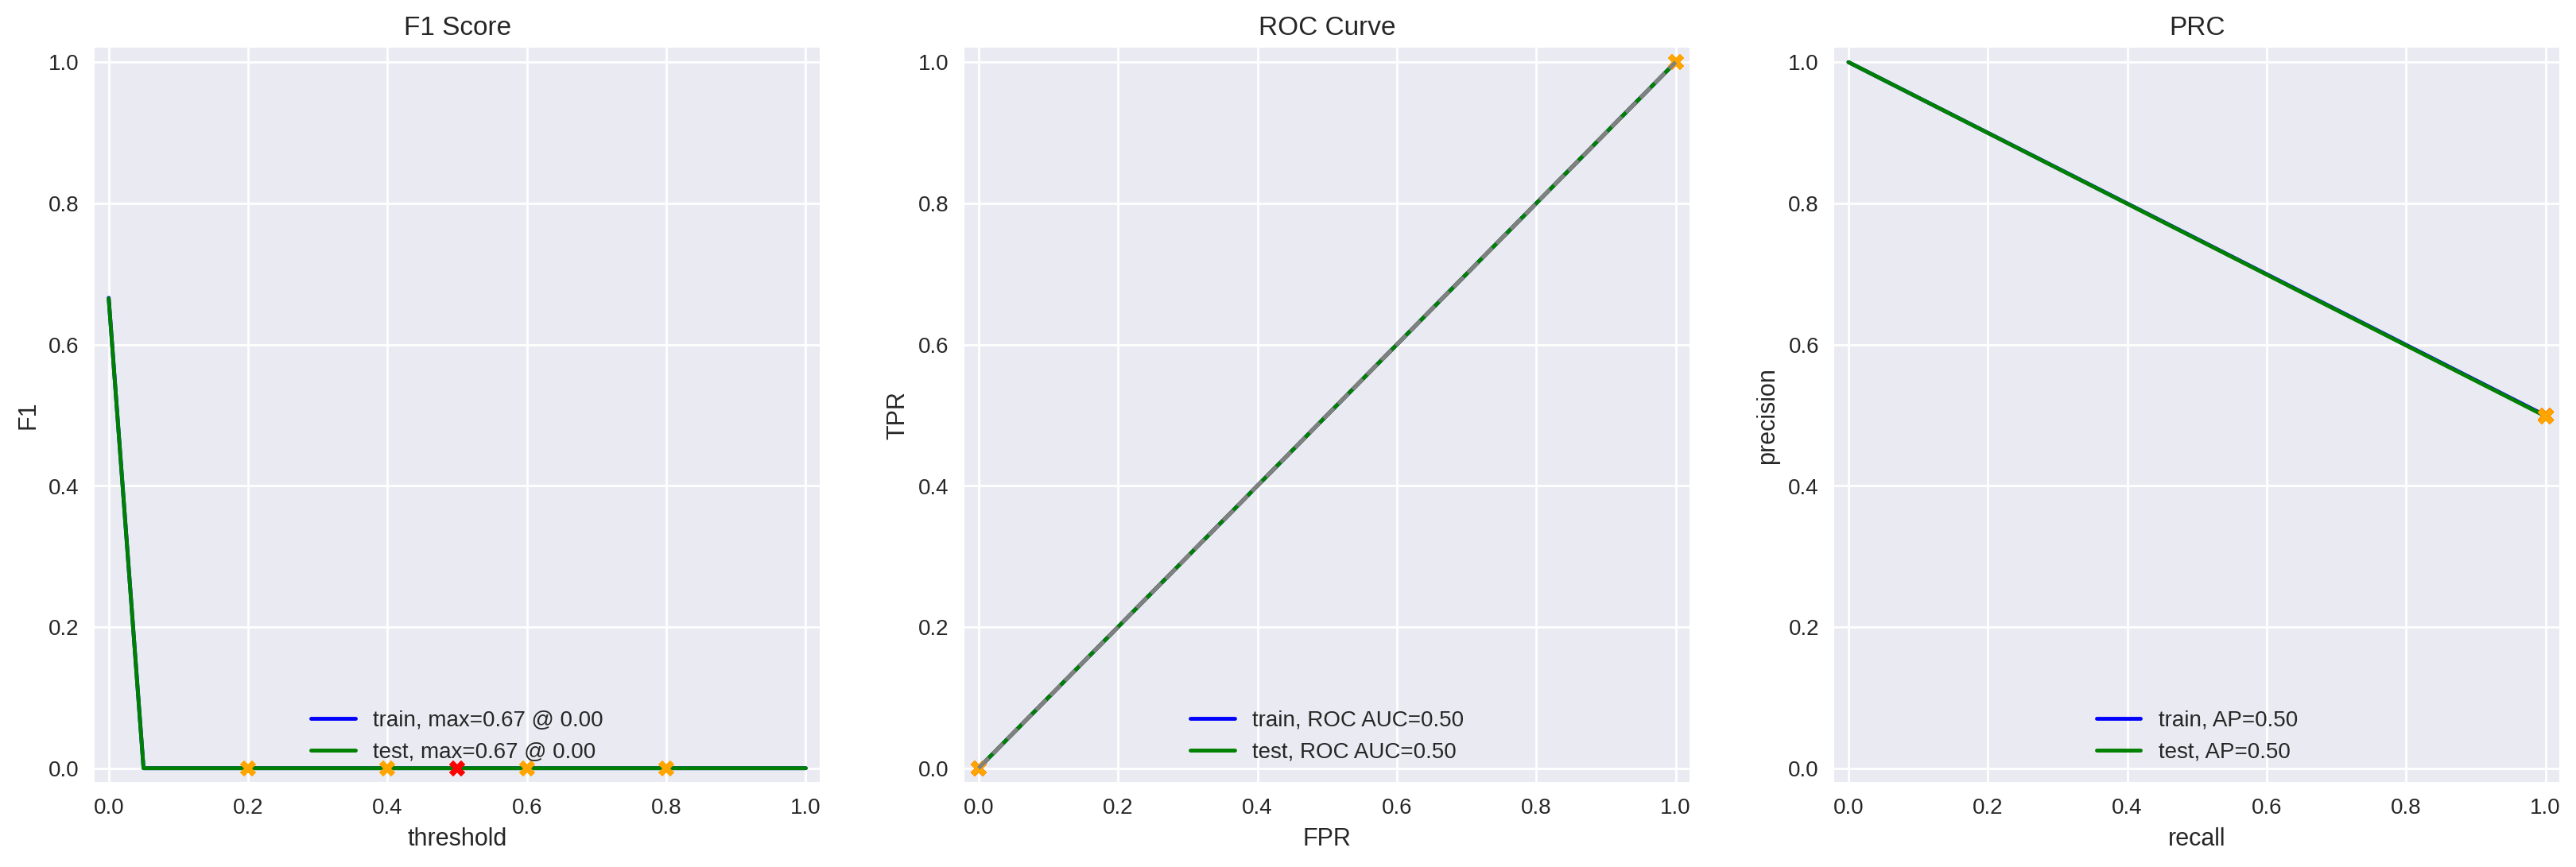

In [26]:
print('Accuracy: Constant Model:', accuracy_score(y_test, y_pred))
print('F1 Score: Contant Model', f1_score(y_test, y_pred))

evaluate_model(dummy_constant, X_train_vect, y_train, X_test_vect, y_test)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english')) 
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [29]:
train_features_1 = X_train_vect
train_target = y_train
test_features_1 = X_test_vect
test_target = y_test

In [30]:
model_1 = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_1.fit(train_features_1, train_target)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [31]:
y_pred = model_1.predict(test_features_1)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


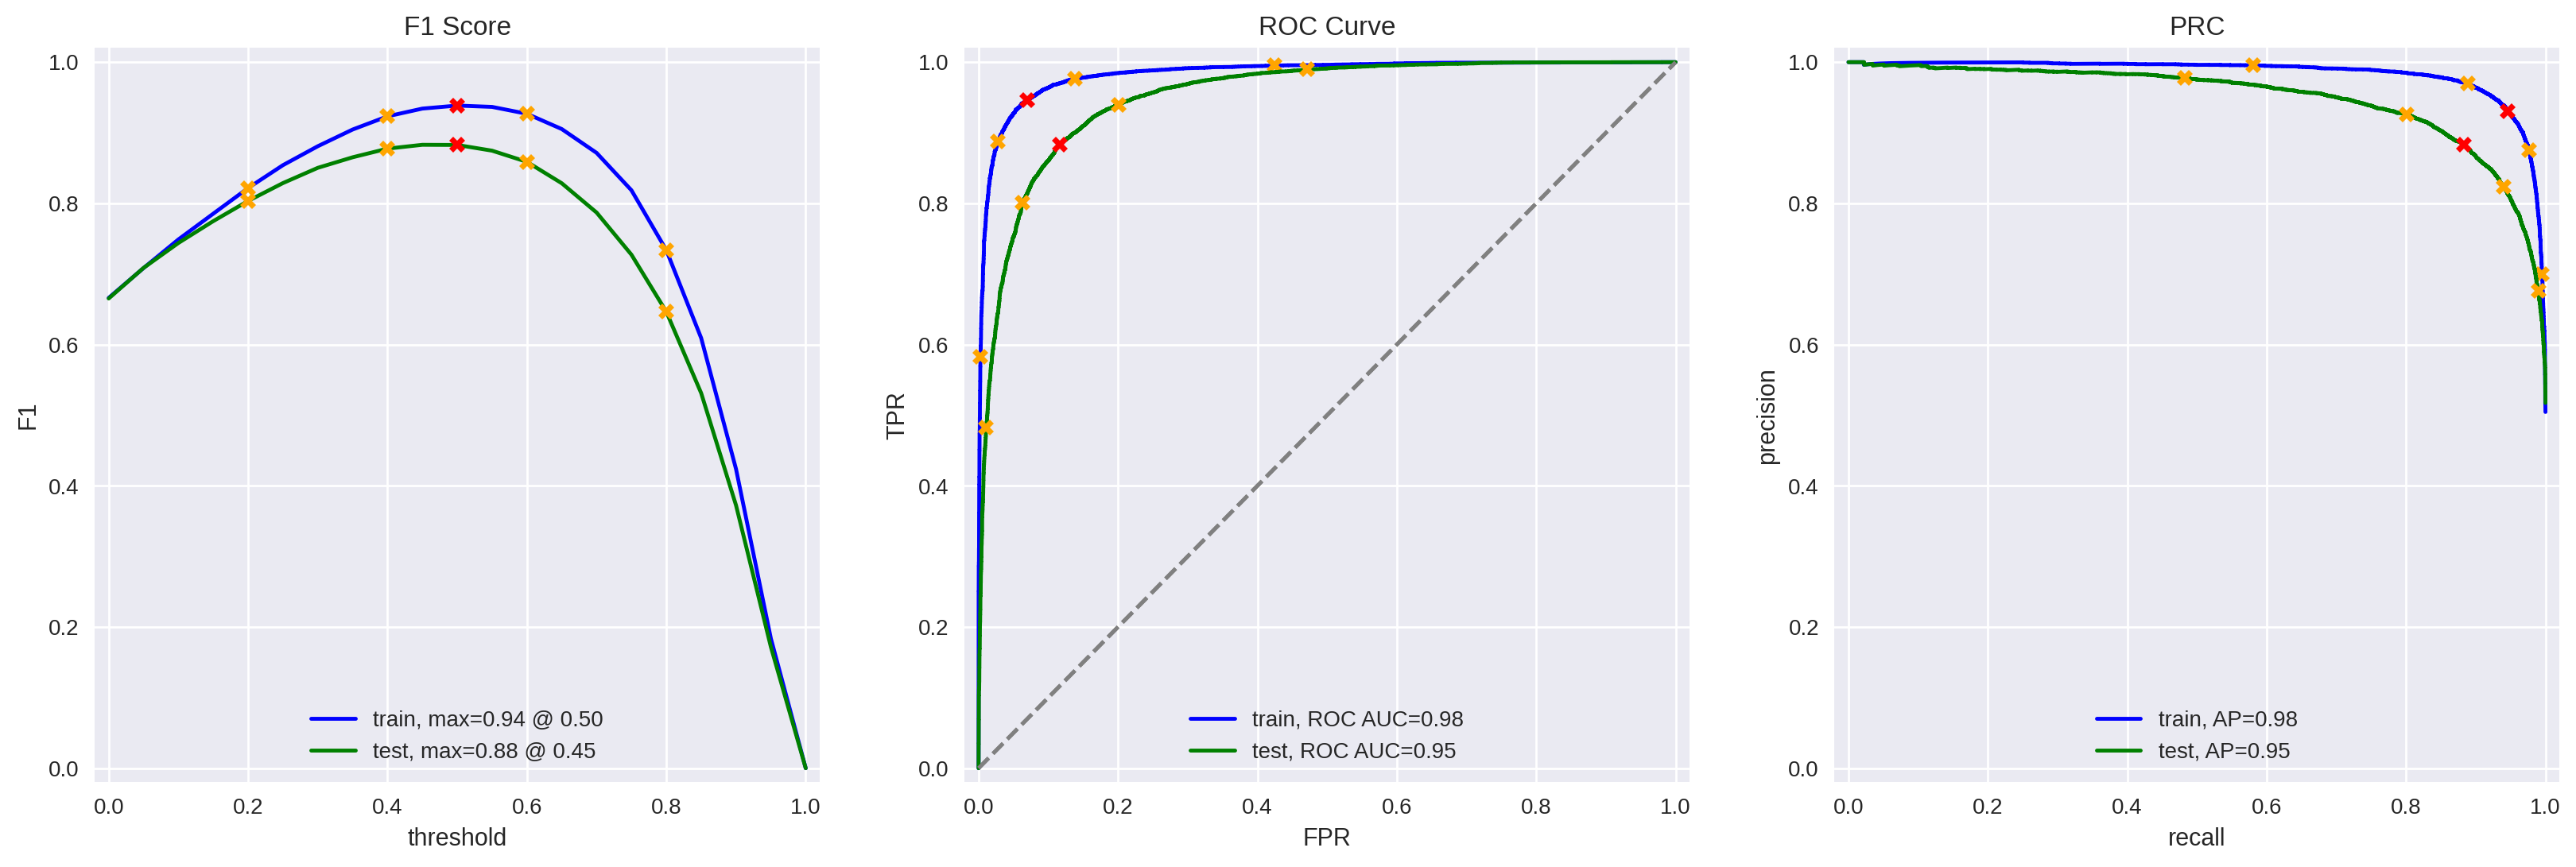

In [32]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

In [33]:
print('Accuracy (Model 1):', accuracy_score(y_test, y_pred))
print('F1 Score (Model 1):', f1_score(y_test, y_pred))

Accuracy (Model 1): 0.883100327200102
F1 Score (Model 1): 0.8827315742359009


### Model 3 - spaCy, TF-IDF and LR

In [34]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [35]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [36]:
df_reviews['review_norm_3'] = df_reviews['review'].progress_apply(text_preprocessing_3)

X_train_3 = df_reviews.query('ds_part == "train"')['review_norm_3']
y_train = df_reviews.query('ds_part == "train"')['pos']

X_test_3 = df_reviews.query('ds_part == "test"')['review_norm_3']
y_test = df_reviews.query('ds_part == "test"')['pos']

  0%|          | 0/47329 [00:00<?, ?it/s]

In [37]:
vectorizer_3 = TfidfVectorizer(max_features=10000)
X_train_vect_3 = vectorizer_3.fit_transform(X_train_3)
X_test_vect_3 = vectorizer_3.transform(X_test_3)

In [38]:
train_features_3 = X_train_vect_3
test_features_3 = X_test_vect_3
train_target = y_train
test_target = y_test

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.97  0.95
Accuracy (Model 3): 0.8807206900947605
F1 Score (Model 3): 0.8803138191276169


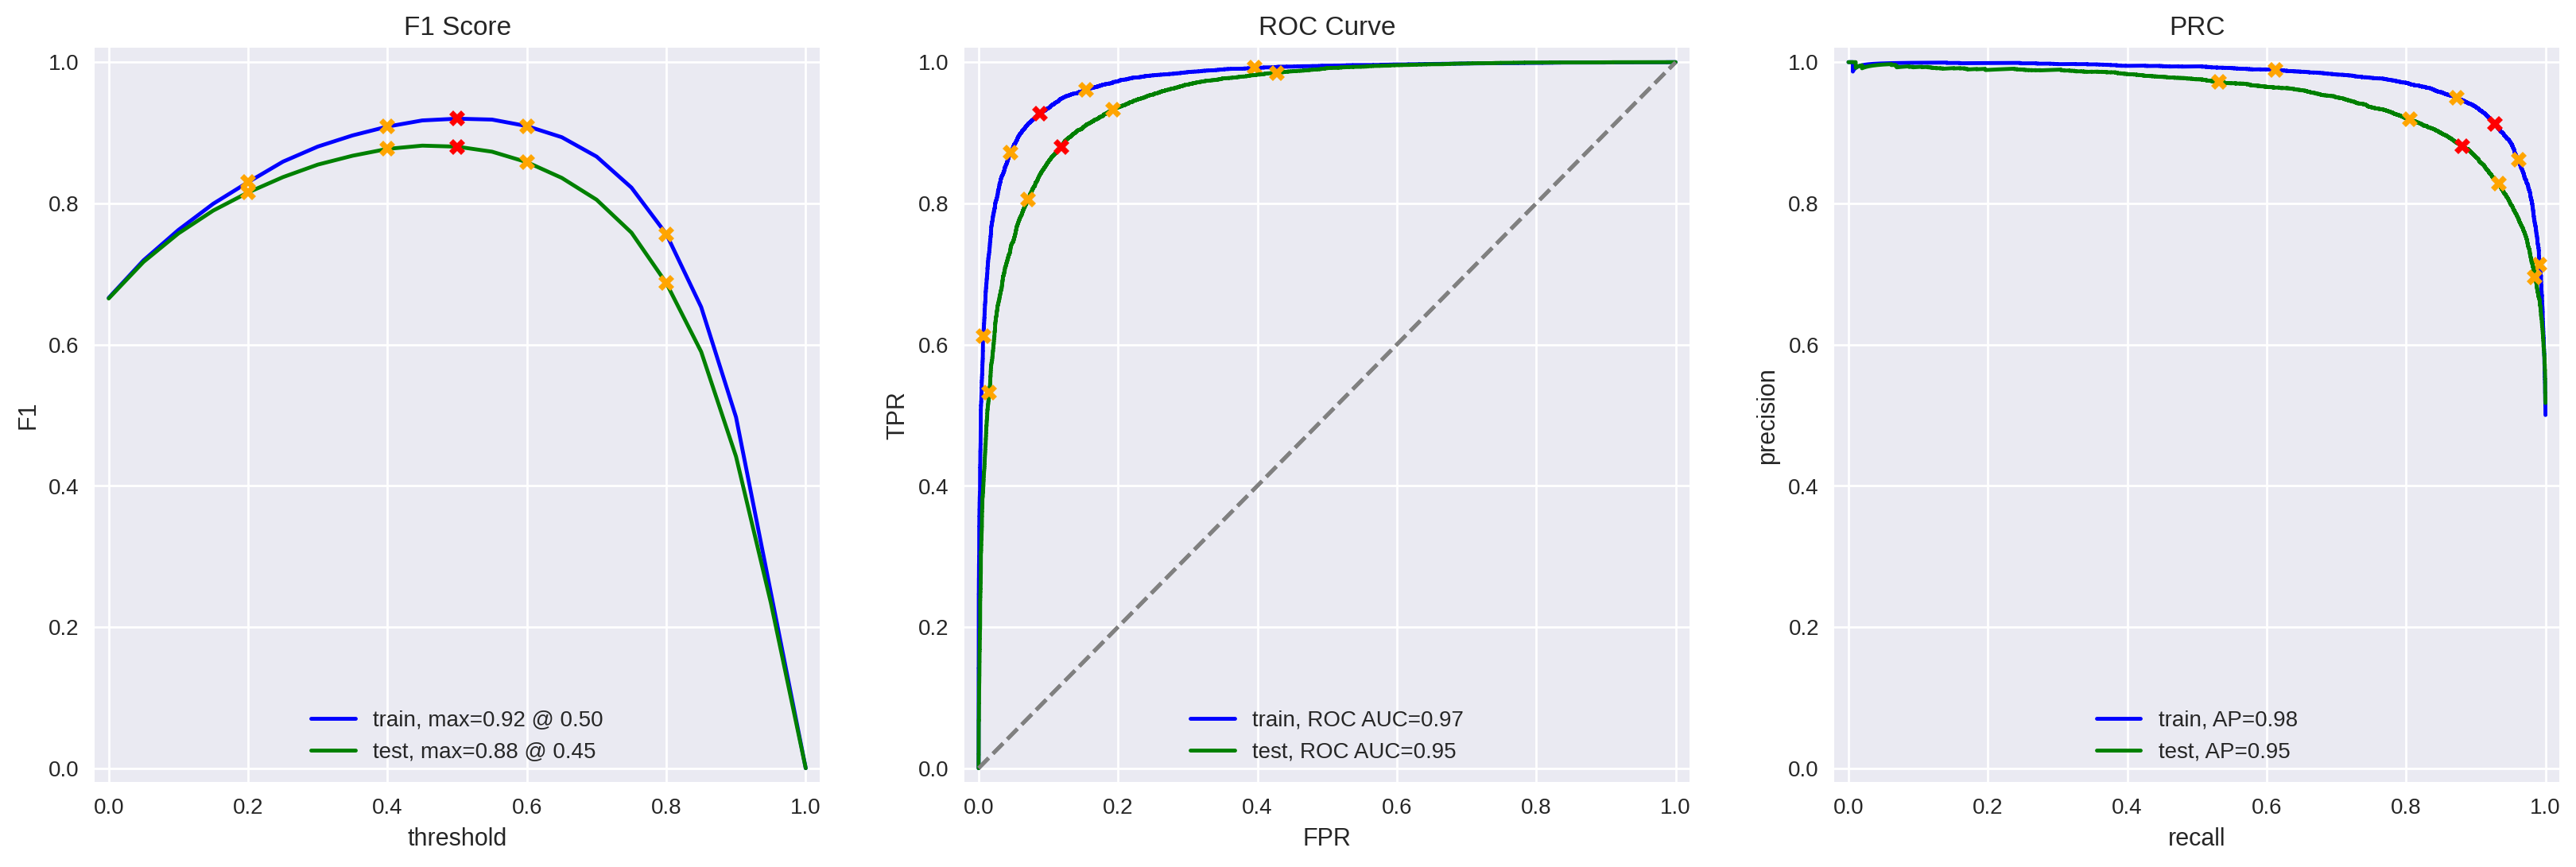

In [39]:
model_3 = LogisticRegression(max_iter=1000)
model_3.fit(train_features_3, train_target)

y_pred_3 = model_3.predict(test_features_3)

evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

print('Accuracy (Model 3):', accuracy_score(test_target, y_pred_3))
print('F1 Score (Model 3):', f1_score(test_target, y_pred_3))

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [40]:
from lightgbm import LGBMClassifier

In [41]:
df_reviews['review_norm_2'] = df_reviews['review'].progress_apply(lambda x: re.sub(r'[^a-z\s]', '', x.lower()))

  0%|          | 0/47329 [00:00<?, ?it/s]

In [42]:
X_train_2 = df_reviews.query('ds_part == "train"')['review_norm_2']
X_test_2 = df_reviews.query('ds_part == "test"')['review_norm_2']
train_target = df_reviews.query('ds_part == "train"')['pos']
test_target = df_reviews.query('ds_part == "test"')['pos']

vectorizer_2 = TfidfVectorizer()
X_train_vect_2 = vectorizer_2.fit_transform(X_train_2)
X_test_vect_2 = vectorizer_2.transform(X_test_2)

train_features_2 = X_train_vect_2
test_features_2 = X_test_vect_2

In [43]:
model_4 = LGBMClassifier(random_state=42)
model_4.fit(train_features_2, train_target)

LGBMClassifier(random_state=42)

In [44]:
y_pred_4 = model_4.predict(test_features_2)

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.94
ROC AUC    0.98  0.94


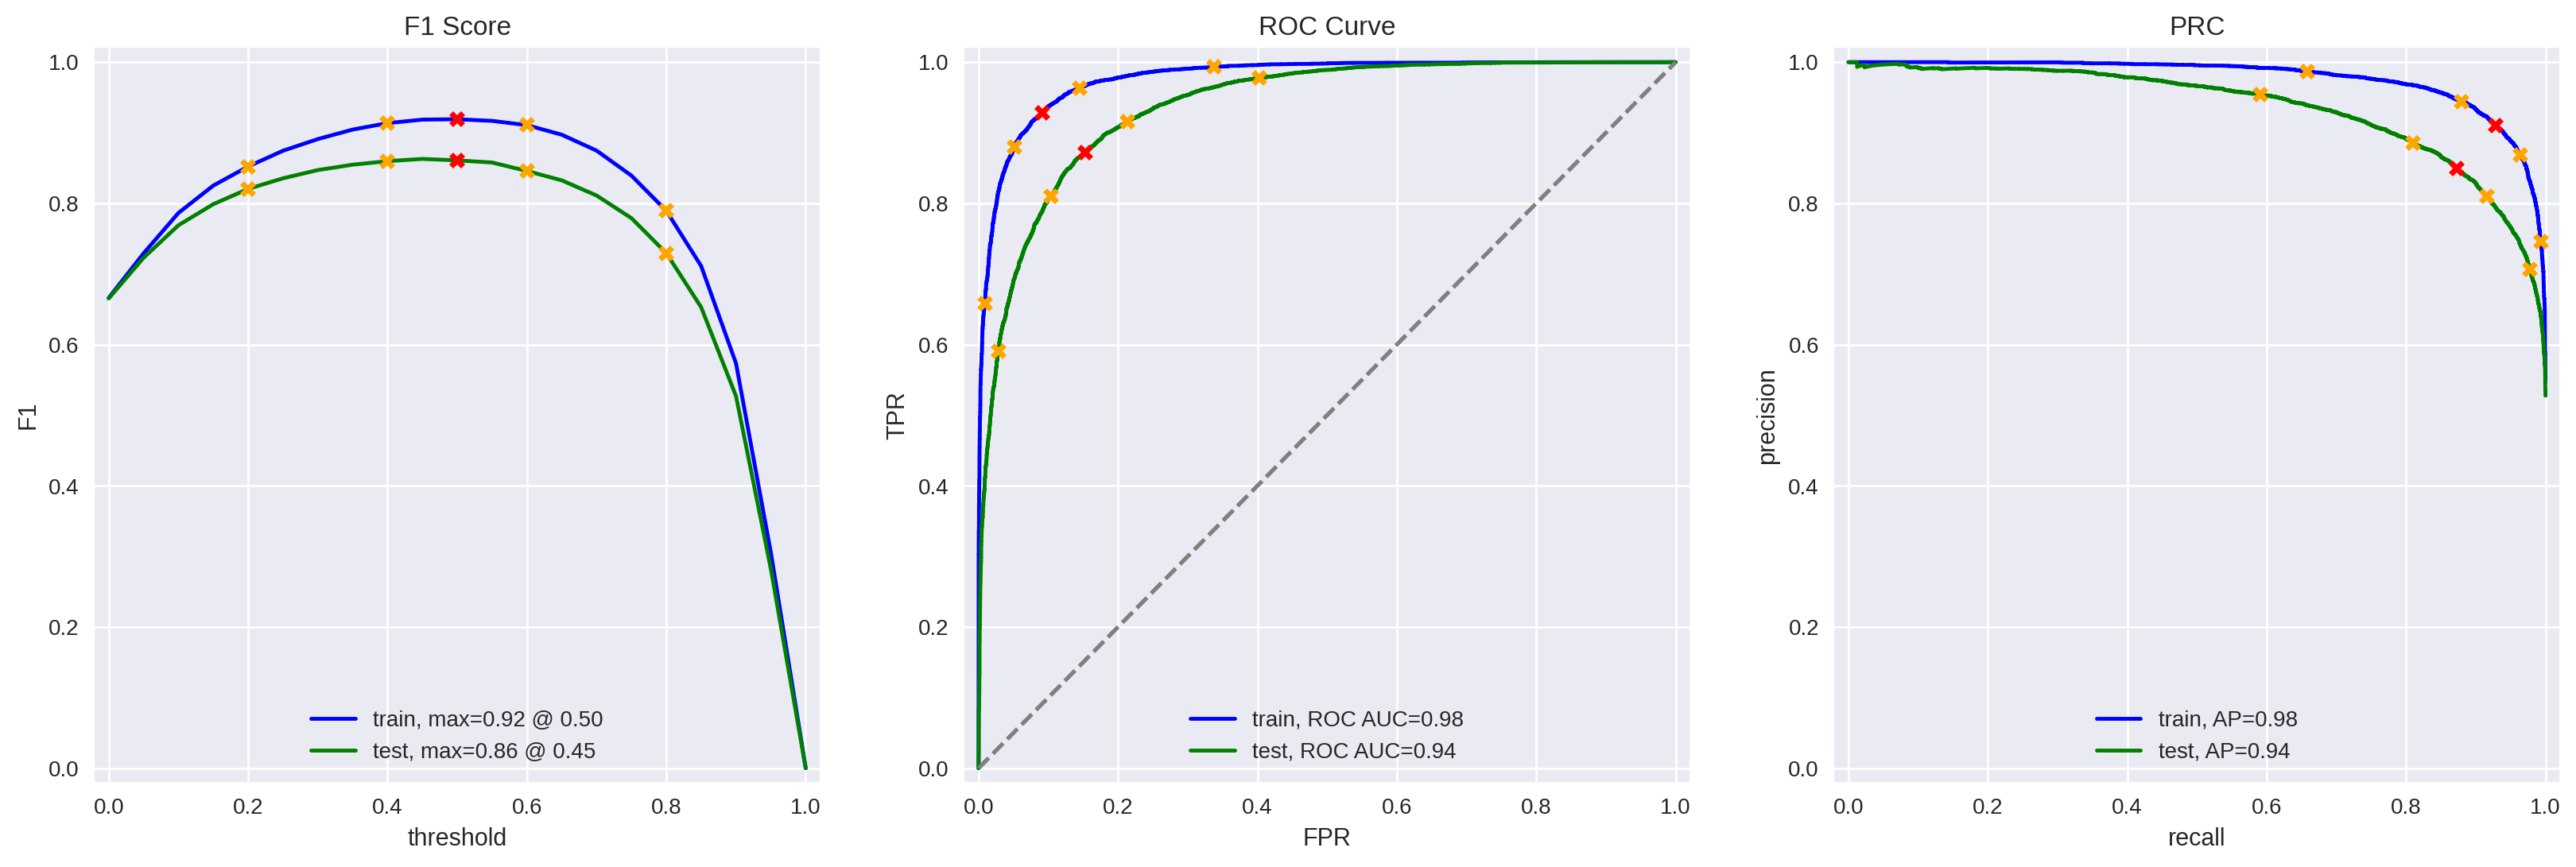

In [45]:
evaluate_model(model_4, train_features_2, train_target, test_features_2, test_target)

In [46]:
print('Accuracy (Model 4):', accuracy_score(test_target, y_pred_4))
print('F1 Score (Model 4):', f1_score(test_target, y_pred_4))

Accuracy (Model 4): 0.8594739302256406
F1 Score (Model 4): 0.860857491479783


###  Model 9 - BERT

In [47]:
import torch
import transformers

In [48]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
def BERT_text_to_embeddings(texts, max_length=128, batch_size=10, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    for text in tqdm(texts, disable=disable_progress_bar):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,    
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids_list.append(encoded['input_ids'].squeeze(0))
        attention_mask_list.append(encoded['attention_mask'].squeeze(0))

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.stack(ids_list[batch_size * i: batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.stack(attention_mask_list[batch_size * i: batch_size * (i + 1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [50]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours

df_reviews_train_subset = df_reviews_train.sample(50, random_state=42)
df_reviews_test_subset = df_reviews_test.sample(50, random_state=42)

y_train_subset = y_train.loc[df_reviews_train_subset.index]
y_test_subset = y_test.loc[df_reviews_test_subset.index]

train_features_9 = BERT_text_to_embeddings(df_reviews_train_subset['review_norm'], force_device='cpu')
test_features_9 = BERT_text_to_embeddings(df_reviews_test_subset['review_norm'], force_device='cpu')

  0%|          | 0/50 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/5 [00:00<?, ?it/s]

*Note:*

*Due to the long computation time required to run BERT embeddings over the full dataset on CPU, 
a random subset of 50 reviews was selected for both train and test sets for the BERT-based model. 
This allowed efficient model training while still demonstrating the ability to work with BERT embeddings.*

In [51]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(50, 768)
(23796,)


In [52]:
model_9 = LogisticRegression(max_iter=1000, random_state=42)
model_9.fit(train_features_9, y_train_subset)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy    1.0  0.64
F1          1.0  0.67
APS         1.0  0.83
ROC AUC     1.0  0.78
Accuracy (Model 9): 0.64
F1 Score (Model 9): 0.6666666666666666


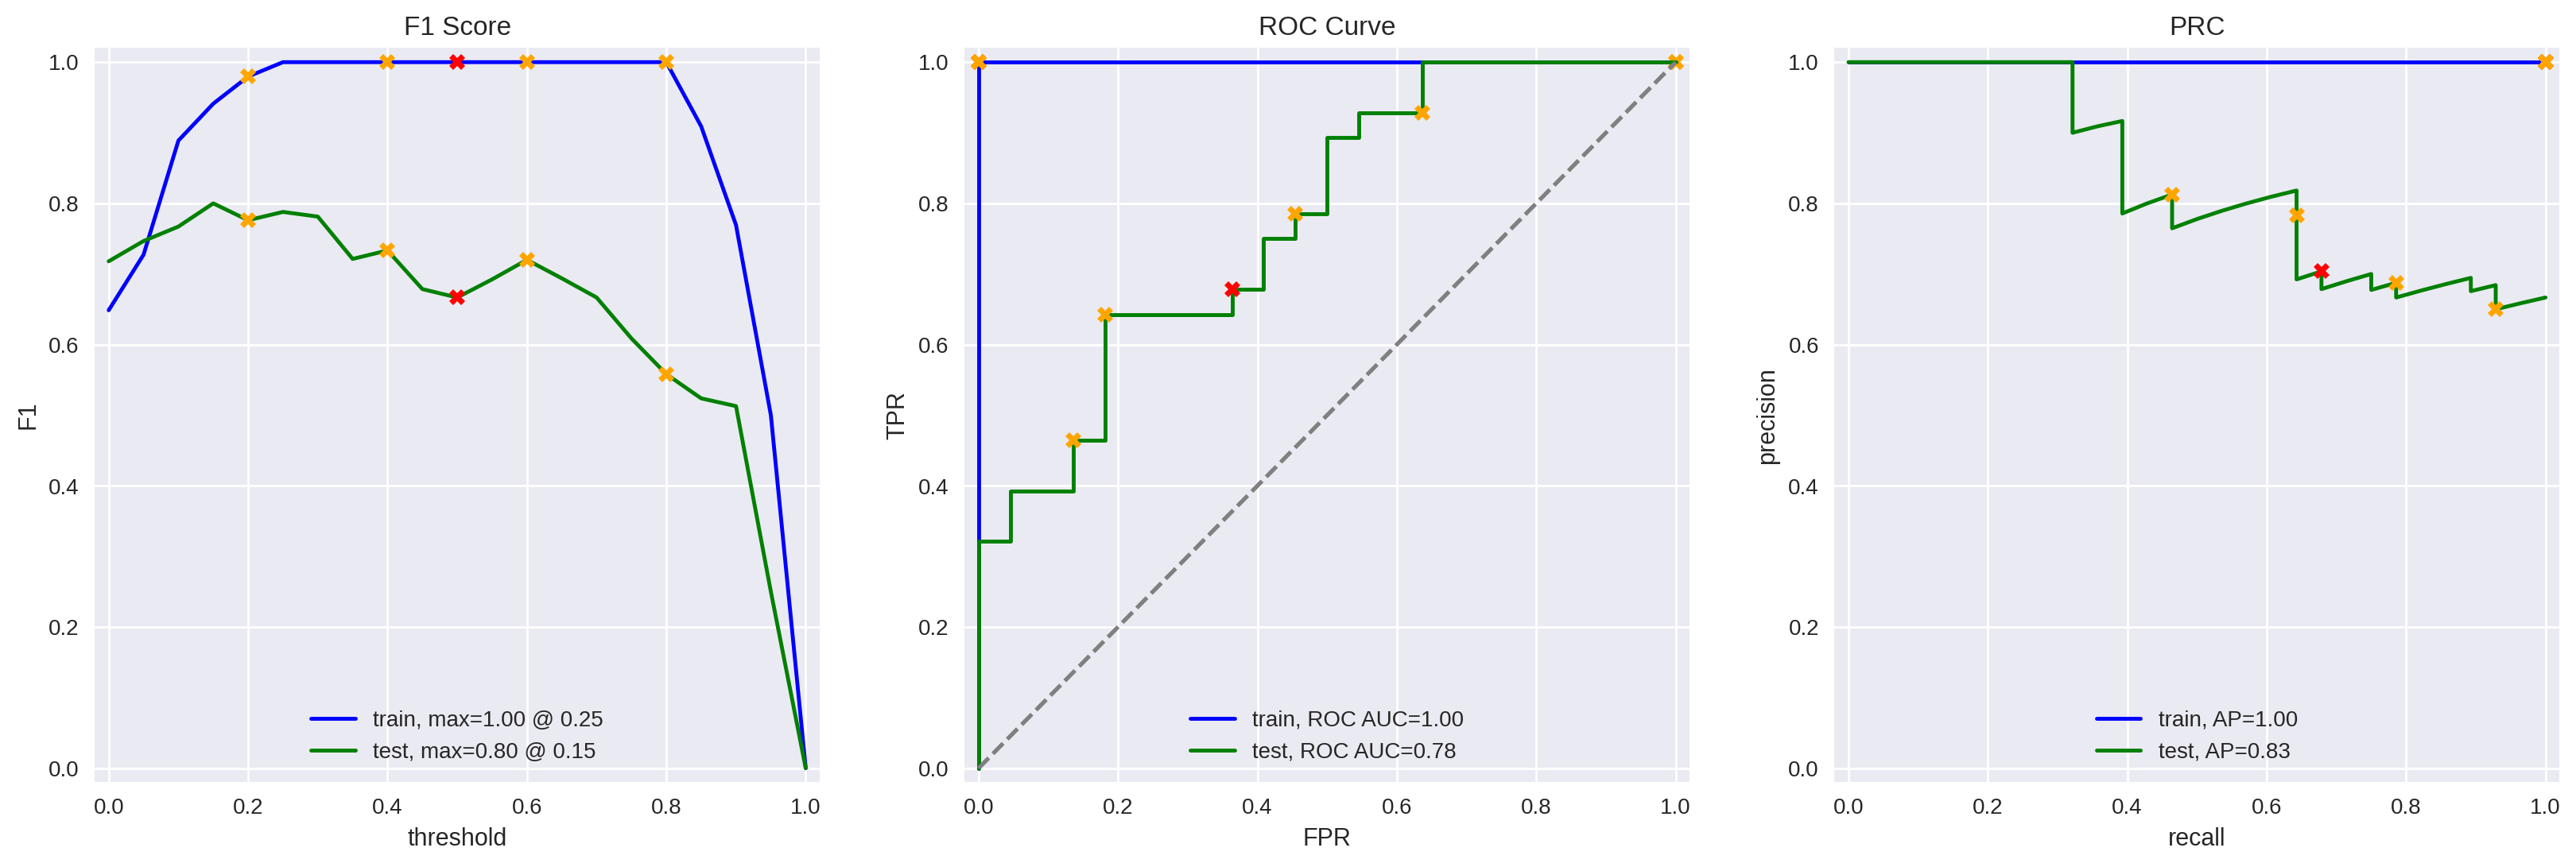

In [53]:
y_pred_9 = model_9.predict(test_features_9)

evaluate_model(model_9, train_features_9, y_train_subset, test_features_9, y_test_subset)

print('Accuracy (Model 9):', accuracy_score(y_test_subset, y_pred_9))
print('F1 Score (Model 9):', f1_score(y_test_subset, y_pred_9))

## My Reviews

### Model 1

In [54]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(
    lambda x: re.sub(r'[^a-z\s]', '', x.lower())
)

In [55]:
texts = my_reviews['review_norm']
my_reviews_pred_prob_1 = model_1.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_1[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [56]:
texts = my_reviews['review_norm']

texts_3 = texts.apply(lambda x: text_preprocessing_3(x))

my_reviews_pred_prob_3 = model_3.predict_proba(vectorizer_3.transform(texts_3))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.18:  i did not simply like it not my kind of movie
0.21:  well i was bored and felt asleep in the middle of the movie
0.52:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.15:  i didnt expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 4

In [57]:
texts = my_reviews['review_norm']

texts_4 = texts 

my_reviews_pred_prob_4 = model_4.predict_proba(vectorizer_2.transform(texts_4))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_4[i]:.2f}:  {review}')

0.62:  i did not simply like it not my kind of movie
0.61:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.52:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.61:  i didnt expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.22:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.60:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 9

In [58]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob_9 = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_9[i]:.2f}:  {review}')

0.36:  i did not simply like it not my kind of movie
0.44:  well i was bored and felt asleep in the middle of the movie
0.94:  i was really fascinated with the movie
0.08:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.05:  i didnt expect the reboot to be so good writers really cared about the source material
0.36:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.08:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.74:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

In this project, the goal was to develop a machine learning model capable of detecting negative movie reviews from IMDB data with an F1 score of at least 0.85:

- Dummy Classifier (Constant): F1 0.502
- Model 1 (NLTK + TF-IDF + Logistic Regression): F1 0.883
- Model 3 (spaCy Lemmatization + TF-IDF + Logistic Regression): F1 0.880
- Model 4 (spaCy Lemmatization + TF-IDF + LightGBM Classifier): F1 0.861
- Model 9 (BERT Embeddings + Logistic Regression): F1 0.667

The best performing model was Model 1 (TF-IDF + Logistic Regression using NLTK stopwords),
with a F1 Score of 0.883 and an Accuracy of 0.883. Model 1 would be recommended for the Film Junky Union's system to automatically detect negative movie reviews.

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions